# Predicting Salaries for MLB Players
**Kevin Payton**

**PSTAT 131 Fall 24**

---
## MLB Information
![](https://logonoid.com/images/mlb-logo.png)

---
## Loading our Data and Libraries

First import my libraries:

In [86]:
# Import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from aquarel import load_theme

And now read all my .csv files:

In [87]:
# Load all datasets
master = pd.read_csv('Master.csv')
salaries = pd.read_csv('Salaries.csv')
batting_stats = pd.read_csv('Batting.csv')
fielding = pd.read_csv('Fielding.csv')

Everything comes from Kaggle at the following link: https://www.kaggle.com/datasets/open-source-sports/baseball-databank?resource=download. I decided on using the Master.csv, Salaries.csv, Fielding.csv, and Batting.csv files which all have data from 1871 through 2015, but I will only be working with data from the year 1990 to 2015. The Master.csv file contains personal information of all the players in the dataset, but I will only be using this to gather the names of players to make importing any future data easier since currently my datasets rely on player IDs. The Salaries.csv file contains team and league information, as well as the salary players have for any given year. The Fielding.csv file contains various fielding statistics, but we only need this for a player's position. Finally, my Batting.csv file contains various batting statistics for players, most of which will be used as my predictors for the dependent variable salary.

---
## Exploring, Merging, and Tidying our Data

Let's start messing with our data and see what needs to be fixed:

In [88]:
# Create a column for a player's full name
master['nameFull'] = master['nameFirst'] + ' ' + master['nameLast']
names = master[['playerID', 'nameFull']]
# Finds amount of rows and columns for names data
print(names.shape)

# Remove all salary data prior to 1990
salaries_post_1990 = salaries[salaries['yearID'] >= 1990]
# Finds amount of rows and columns for salaries data
print(salaries_post_1990.shape)

# Merge our salaries and names data on an inner join
merged_data = pd.merge(salaries_post_1990, names, on='playerID', how='inner')
# Finds amount of rows and columns for the merged data
print(merged_data.shape)

(18846, 2)
(22286, 5)
(22278, 6)


I first decided to make a full name column because the player's first and last names were separated in our Master.csv file. I then removed all columns except the `playerID` and `nameFull` to make the merging with salaries easier since all the other columns were unneeded. This left us with 18846 rows and 2 columns, with the rows each representing players. We are left with so many because we currently still have values from every player that has played since 1871 through 2015, but all those prior to 1990 will be removed once we merge with our salaries dataset. 

I then filtered out all player data from Salaries.csv prior to 1990 to simplify things, leaving us with 22286 rows and 5 columns containing simple data about a player, the team they started the season and its league, as well as the year and their salary. This file does not contain information on if a player was traded during the year, because their salary stays the same. This is an issue I might have later when dealing with the batting information, because there might be multiple rows for the same player during a given year.

I was then able to finally merge the two datasets together with an inner join and once again printed the shape. As you can see above, we were missing 8 player's names from the names data frame so I will create a function to discover the index of these players, as well as their `playerID` so I can try and find some more information about them in our Master.csv file.

In [89]:
merged_data_left = pd.merge(salaries_post_1990, names, on='playerID', how='left')

null_data = merged_data_left['nameFull'].isnull()
missing_names = []

for ind in merged_data_left.index:
    if null_data.iloc[ind] == True:
        missing_names.append(merged_data_left.loc[ind, 'playerID'])
    
print(missing_names)

['harriwi10', 'castiru02', 'rosajo01', 'arrueba01', 'furcara02', 'castiru02', 'rosajo01', 'harriwi10']


It seems like we have 5 unique incorrect `playerID`s that were missing information in our Master.csv file but were in our Salaries.csv file. First let's simply just try to loop through Master.csv and see if there is any information in it.

In [90]:
for playerid in missing_names:
    print(master.loc[master['playerID'] == playerid])

Empty DataFrame
Columns: [playerID, birthYear, birthMonth, birthDay, birthCountry, birthState, birthCity, deathYear, deathMonth, deathDay, deathCountry, deathState, deathCity, nameFirst, nameLast, nameGiven, weight, height, bats, throws, debut, finalGame, retroID, bbrefID, nameFull]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [playerID, birthYear, birthMonth, birthDay, birthCountry, birthState, birthCity, deathYear, deathMonth, deathDay, deathCountry, deathState, deathCity, nameFirst, nameLast, nameGiven, weight, height, bats, throws, debut, finalGame, retroID, bbrefID, nameFull]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [playerID, birthYear, birthMonth, birthDay, birthCountry, birthState, birthCity, deathYear, deathMonth, deathDay, deathCountry, deathState, deathCity, nameFirst, nameLast, nameGiven, weight, height, bats, throws, debut, finalGame, retroID, bbrefID, nameFull]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [playerID, birthYear, bi

Unfortunately, I was unable to find these names simply from going through the file, so I will have to do some extra research in case the ID was simply input wrong.

I was first able to discover that the player with the ID 'harriwi10' was Will Harris and was given the ID 'harriwi02' in both Master.csv and Batting.csv. The player with the ID 'castiru02' was Rusney Castillo with the ID 'castiru01'. The player with the ID 'rosajo01' was Jorge De La Rosa and also had data under the ID 'delarjo01'. The player with the ID 'arrueba01' was Erisbel Arruebarrena who also had data under the ID 'arrueer01'. Finally, the player with the ID 'furcara02' was Rafael Furcal who also had data under 'furcara01'.

In [91]:
salaries_post_1990.loc[salaries_post_1990.playerID == 'harriwi10', 'playerID'] = 'harriwi02'
salaries_post_1990.loc[salaries_post_1990.playerID == 'castiru02', 'playerID'] = 'castiru01'
salaries_post_1990.loc[salaries_post_1990.playerID == 'rosajo01', 'playerID'] = 'delarjo01'
salaries_post_1990.loc[salaries_post_1990.playerID == 'arrueba01', 'playerID'] = 'arrueer01'
salaries_post_1990.loc[salaries_post_1990.playerID == 'furcara02', 'playerID'] = 'furcara01'

final_merged_data = pd.merge(salaries_post_1990, names, on='playerID', how='inner')

Now the set of data containg the player names and salaries should be all cleaned up and ready, so we just need to work on the batting stats and getting everything merged together.

In [92]:
batting_stats = batting_stats[batting_stats['yearID'] >= 1990]
print(batting_stats.shape)
print(batting_stats.isnull().sum())

(33924, 22)
playerID       0
yearID         0
stint          0
teamID         0
lgID           0
G              0
AB          2049
R           2049
H           2049
2B          2049
3B          2049
HR          2049
RBI         2049
SB          2049
CS          2049
BB          2049
SO          2049
IBB         2049
HBP         2049
SH          2049
SF          2049
GIDP        2049
dtype: int64


In [93]:
batting_stats.dropna(subset=['AB'], inplace=True)

We had a lot of null values for our batting stats, presumably for players who were pitchers and weren't required to bat, so I removed all of those. This will make it easier to work with our data. Now all I need to do is combine the rows for players who were traded during the season

In [94]:
stats = ['G','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','IBB','HBP','SH','SF','GIDP']
new_batting = batting_stats.groupby(['playerID', 'yearID'])[stats].sum().reset_index()
new_merged = pd.merge(new_batting, final_merged_data, on=['playerID', 'yearID'], how='inner')

Now all our batting data is grouped together by year and player and we were able to merge our data sets together, leaving us with 20337 rows and 23 columns. Now we can add all the positions to remove pitchers because they should not be judged based on their battings stats.

In [95]:
new_fielding = fielding[['playerID', 'yearID', 'POS', 'G']]
new_fielding = new_fielding[new_fielding['yearID'] >= 1990]
fielding_counts = new_fielding.groupby(['playerID', 'yearID', 'POS'])['G'].sum().reset_index()
fielding_counts.sort_values(by=['playerID','yearID','G'], ascending=False, inplace=True)
fielding_counts.drop_duplicates(subset=['playerID', 'yearID'], keep='first', inplace=True)
fielding_counts.drop('G', axis=1, inplace=True)

Due to the fact that players can play multiple positions in a given season, to add the position data I first had to sum up all the games played for a specific positon for each given year for each player. I was then able to sort these new values and drop all the rows for positions that weren't the most played for every player. I then finally removed our games played column because all we wanted was every player's most played position.

In [96]:
final_merge = pd.merge(fielding_counts, new_merged, on=['playerID', 'yearID'], how='inner')
final_no_pitchers = final_merge[final_merge.POS != 'P']
final_data = final_no_pitchers[['playerID', 'nameFull', 'yearID', 'POS', 'salary', 'teamID',
                        'lgID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS',
                        'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']]
print(final_data.shape)
print(final_data.columns)

(11399, 24)
Index(['playerID', 'nameFull', 'yearID', 'POS', 'salary', 'teamID', 'lgID',
       'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO',
       'IBB', 'HBP', 'SH', 'SF', 'GIDP'],
      dtype='object')


In [97]:
final_data['POS'] = final_data['POS'].astype('category')
final_data['lgID'] = final_data['lgID'].astype('category')
final_data['teamID'] = final_data['teamID'].astype('category')

After removing pitchers and moving around our columns, we are finally left with 11399 rows and 24 columns containing batting and salary information about most MLB players from 1990 to 2015.

In [98]:
final_data = final_data[final_data.G >= 20]

I also decided to remove all player data for those who played less than 20 games, because they might skew our model if they have high salaries and low stats.

---
## Exploratory Data Analysis

Now, we will explore the relationships between all our variables! First let's load a theme to make our graphs look fancy.

In [99]:
theme = load_theme('umbra_dark')
theme.apply()

We'll first simply look at a summary of basic statistics for each of our variables.

In [100]:
final_data.describe()

,yearID,salary,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,10727.000000,1.072700e+04,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000
mean,2002.328796,2.554612e+06,104.923930,340.271278,47.017992,91.249557,17.905659,1.930083,10.439918,44.882353,6.557751,2.793232,33.862217,62.599608,2.809826,3.288897,2.085578,2.949753,7.831080
std,7.408623,3.804878e+06,39.907674,176.838052,30.302326,53.275029,11.549206,2.303828,10.120830,31.040736,9.685219,3.286968,24.554673,36.717511,4.187277,3.574383,2.959504,2.522912,5.532623
min,1990.000000,0.000000e+00,20.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1996.000000,3.500000e+05,74.000000,182.000000,21.000000,44.000000,8.000000,0.000000,3.000000,19.000000,1.000000,0.000000,15.000000,33.000000,0.000000,1.000000,0.000000,1.000000,3.000000
50%,2002.000000,8.000000e+05,110.000000,341.000000,43.000000,88.000000,17.000000,1.000000,7.000000,39.000000,3.000000,2.000000,29.000000,58.000000,1.000000,2.000000,1.000000,2.000000,7.000000
75%,2009.000000,3.200000e+06,141.000000,498.000000,70.000000,136.000000,26.000000,3.000000,15.000000,65.000000,8.000000,4.000000,48.000000,86.000000,4.000000,5.000000,3.000000,4.000000,11.000000
max,2015.000000,3.300000e+07,163.000000,716.000000,152.000000,262.000000,59.000000,23.000000,73.000000,165.000000,78.000000,28.000000,232.000000,223.000000,120.000000,34.000000,39.000000,17.000000,32.000000


For some reason, we have players in our dataset that have a salary of 0, so let's fix that.

In [101]:
final_data.loc[final_data.playerID == 'jamesdi01', 'salary'] = 109000
final_data.describe()

,yearID,salary,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
count,10727.000000,1.072700e+04,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000,10727.000000
mean,2002.328796,2.554524e+06,104.923930,340.271278,47.017992,91.249557,17.905659,1.930083,10.439918,44.882353,6.557751,2.793232,33.862217,62.599608,2.809826,3.288897,2.085578,2.949753,7.831080
std,7.408623,3.804930e+06,39.907674,176.838052,30.302326,53.275029,11.549206,2.303828,10.120830,31.040736,9.685219,3.286968,24.554673,36.717511,4.187277,3.574383,2.959504,2.522912,5.532623
min,1990.000000,1.000000e+05,20.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1996.000000,3.500000e+05,74.000000,182.000000,21.000000,44.000000,8.000000,0.000000,3.000000,19.000000,1.000000,0.000000,15.000000,33.000000,0.000000,1.000000,0.000000,1.000000,3.000000
50%,2002.000000,8.000000e+05,110.000000,341.000000,43.000000,88.000000,17.000000,1.000000,7.000000,39.000000,3.000000,2.000000,29.000000,58.000000,1.000000,2.000000,1.000000,2.000000,7.000000
75%,2009.000000,3.200000e+06,141.000000,498.000000,70.000000,136.000000,26.000000,3.000000,15.000000,65.000000,8.000000,4.000000,48.000000,86.000000,4.000000,5.000000,3.000000,4.000000,11.000000
max,2015.000000,3.300000e+07,163.000000,716.000000,152.000000,262.000000,59.000000,23.000000,73.000000,165.000000,78.000000,28.000000,232.000000,223.000000,120.000000,34.000000,39.000000,17.000000,32.000000


Now let's make a correlation matrix with all our continuous numerical variables (`yearID`, `salary`, `G`, `AB`, `R`, `H`, `2B`, `3B`, `HR`, `RBI`, `SB`, `CS`, `BB`, `SO`, `IBB`, `HBP`, `SH`, `SF`, `GIDP`) to see how they are correlated with each other. 

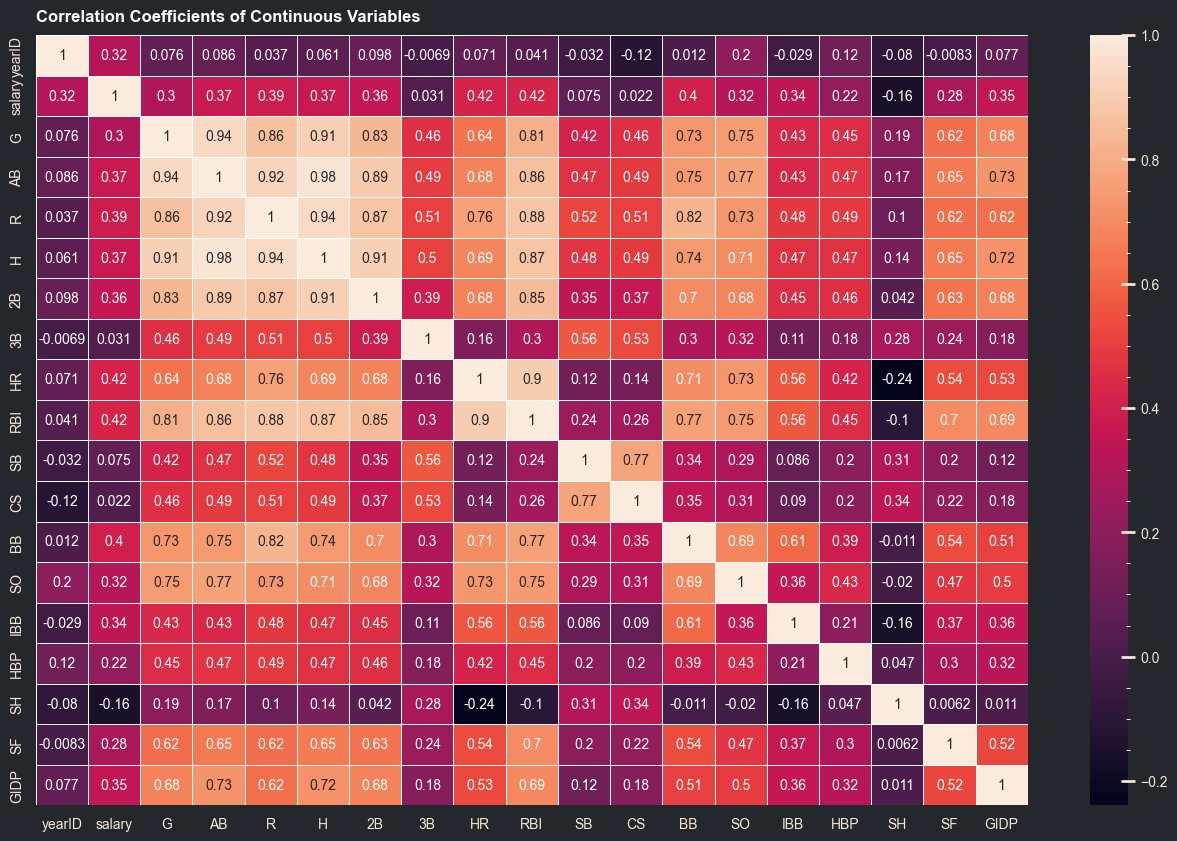

In [121]:
plt.figure(figsize=(16, 10))
sns.heatmap(final_data.corr(numeric_only=True), annot=True, linewidth=.5)
plt.title('Correlation Coefficients of Continuous Variables')
plt.tick_params(left=False, bottom=False, which='both')
plt.grid(visible=False, which='both')
plt.show()

Before doing any exploration between our variables, lets look at the distribution of our dependent variable `salary`:

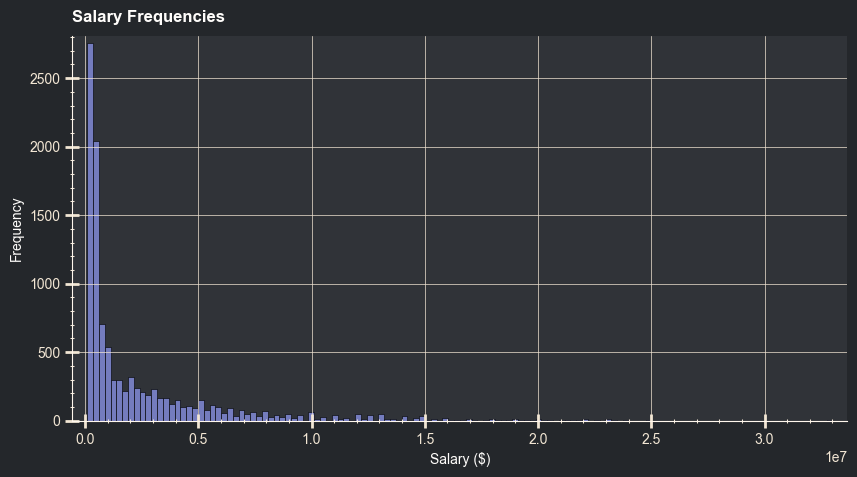

In [103]:
plt.figure(figsize=(10,5))
sns.histplot(data=final_data, x='salary')
plt.xlabel('Salary ($)')
plt.ylabel('Frequency')
plt.title('Salary Frequencies')
plt.show()

ad

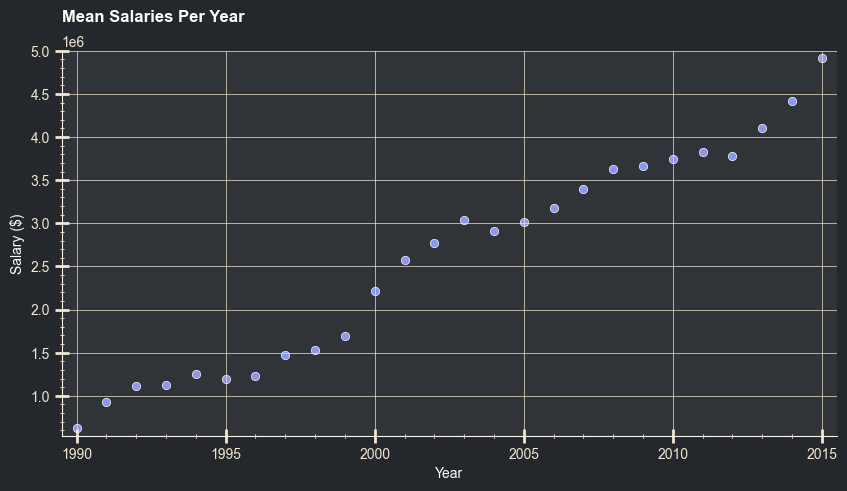

In [104]:
mean_salaries = final_data.groupby(by=['yearID'])['salary'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.scatterplot(data=mean_salaries, x='yearID', y='salary')
plt.xlabel('Year')
plt.ylabel('Salary ($)')
plt.title('Mean Salaries Per Year')
plt.show()

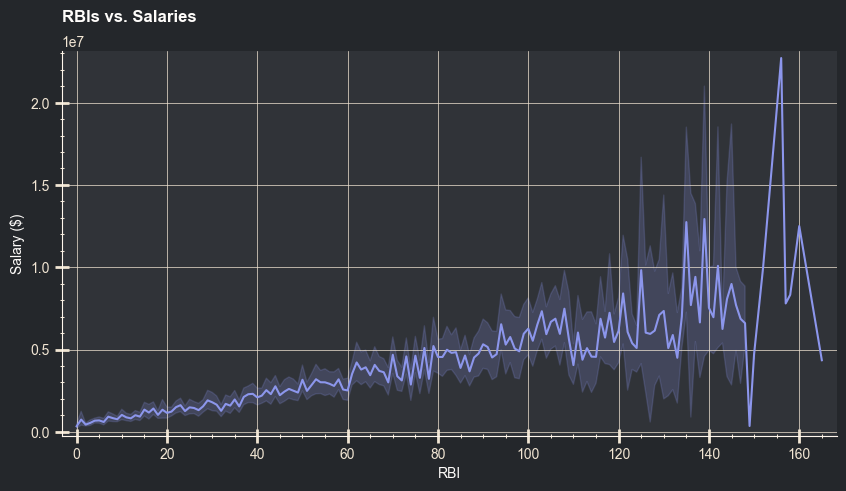

In [105]:
plt.figure(figsize=(10,5))
sns.lineplot(data=final_data, x='RBI', y='salary')
plt.xlabel('RBI')
plt.ylabel('Salary ($)')
plt.title('RBIs vs. Salaries')
plt.show()

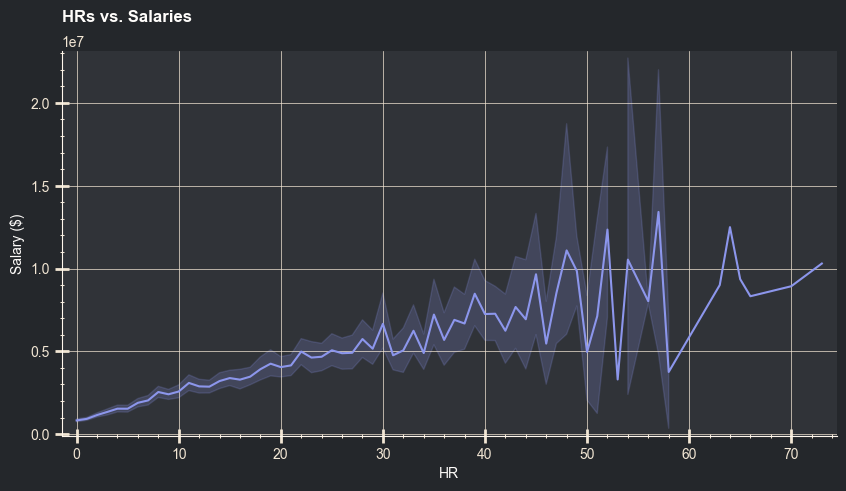

In [106]:
plt.figure(figsize=(10,5))
sns.lineplot(data=final_data, x='HR', y='salary')
plt.xlabel('HR')
plt.ylabel('Salary ($)')
plt.title('HRs vs. Salaries')
plt.show()

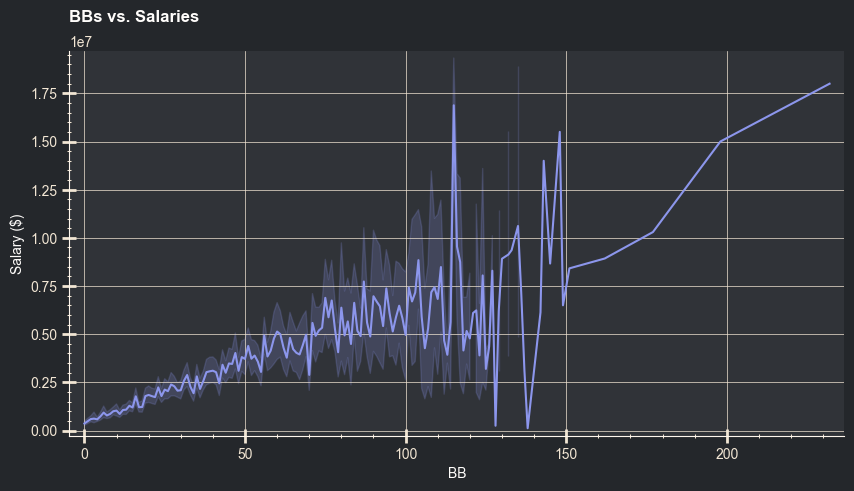

In [107]:
plt.figure(figsize=(10,5))
sns.lineplot(data=final_data, x='BB', y='salary')
plt.xlabel('BB')
plt.ylabel('Salary ($)')
plt.title('BBs vs. Salaries')
plt.show()

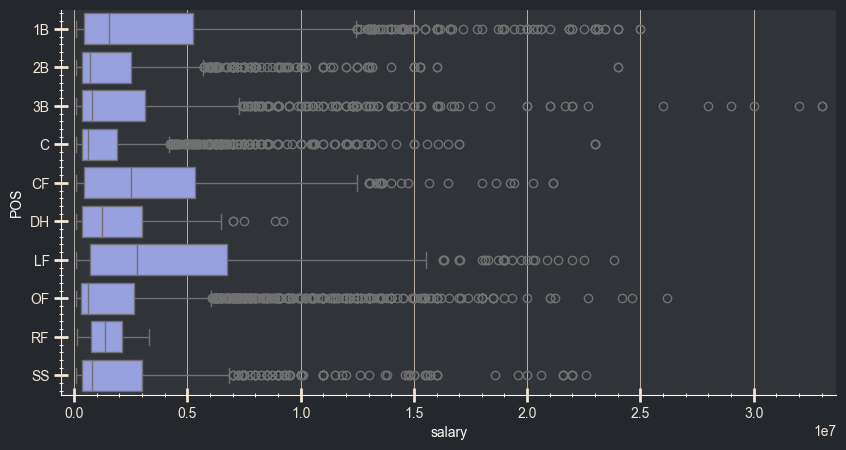

In [108]:
plt.figure(figsize=(10,5))
sns.boxplot(data=final_data, x='salary', y='POS')
plt.show()

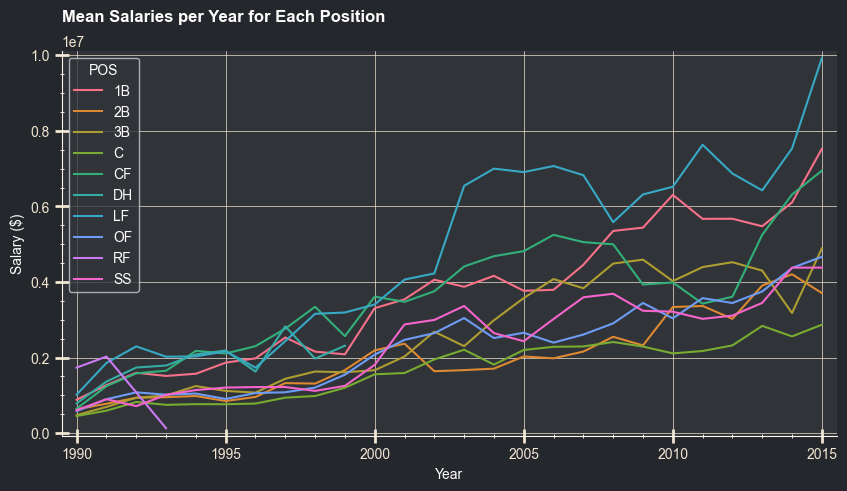

In [118]:
mean_salaries = final_data.groupby(by=['yearID', 'POS'], observed=True)['salary'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=mean_salaries, x='yearID', y='salary', hue='POS')
plt.xlabel('Year')
plt.ylabel('Salary ($)')
plt.title('Mean Salaries per Year for Each Position')
plt.show()

---
## Setting up for our Models

---
## Model Building

---
## Model Results